# Introduction to Variational Autoencoders with Pyro
Welcome to this introductory Jupyter Notebook on Variational Autoencoders (VAEs) built using Pyro! In this tutorial, we will explore the fascinating world of generative models and dive into the inner workings of VAEs.

Generative models are a powerful class of machine learning algorithms that can learn to generate new data samples similar to the training data. VAEs, in particular, are a type of generative model that combines techniques from both deep learning and probabilistic modeling. They allow us to capture complex patterns and generate new samples from high-dimensional data distributions.

# Sections
0. Setup
1. Defining the Encoder
2. Defining the Decoder
3. Defining the VAE (Model & Guide)
4. Inference and Results

## 0. Setup
In this section, we will set up the necessary environment and dependencies for working with Variational Autoencoders (VAEs) in Pyro. We will install any required packages, import the necessary libraries, and load the dataset (if applicable). It is important to have a properly configured environment before proceeding to the subsequent sections.

In [1]:
!pip3 install -r requirements.txt

import pyro
import torch
from pyro import distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.contrib.examples.util import MNIST
import pyro.poutine as poutine
import torchvision.transforms as transforms
from torch import nn
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.manifold import TSNE
import plotly.express as px
from torchsummary import summary
from itertools import chain
import plotly.express as px

Ignoring colorama: markers 'python_version >= "3.8" and python_version < "4.0" and platform_system == "Windows"' don't match your environment


/home/marco/.cache/pypoetry/virtualenvs/introduction-to-pyro-pyladies-z0o6Ogaw-py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Before getting into th emodelling we should set up our torch data loadsers.
# For more details on data loaders and other PyTorch concepts referenced in this tutorial, feel
# free to check out the previous PyLadies introduction to PyTorch:
# https://github.com/pyladiesams/deepLearningPyTorch-beginner-nov2022
def setup_data_loaders(batch_size=128):
    # We define some common parameters across both the training and testloader
    # The data will be downloaded and stored in the ./data folder; on subsequent runs, we
    # do not have to start the download again.
    # Note: You can set the 'download' parameter to False, if you do not want to locally
    # store the MNIST images.
    # Lastly, we define a convenient transformation of the MNIST digits converting them to torch tensors.
    # The resulting torch tensors will have the shape (1, 28, 28).
    # The leftmost dimension represents the color-intensity. As we are dealing with grayscale images,
    # this dimension has size 1. Dimensions two and three define the height and width of the images in pixels.
    root = './data'
    download = True
    trans = transforms.ToTensor()
    
    # We apply the above options to load the training set and the testing set
    # of the MNIST digits dataset.
    train_set = MNIST(
        root=root,
        train=True,
        transform=trans,
        download=download
    )
    test_set = MNIST(
        root=root,
        train=False,
        transform=trans,
        download=download
    )
    
    # Lastly, we initialize the dataloaders, that we will iterate on during
    # training and testing later on. 
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, test_loader

## 1. Defining the Encoder
The encoder is a crucial component of the Variational Autoencoder (VAE) architecture. In this section, we will define the encoder network, which takes an input data sample and maps it to the corresponding latent space representation. We will explore various architectures and techniques for constructing the encoder network, such as fully connected layers, convolutional layers, and activation functions. Understanding the encoder's role and designing an effective architecture is essential for the overall performance of the VAE.

In [3]:
# This is the encoder, that we will use to map the input samples (MNIST digits) to the latent space.
# Note, that there is nothing probabalistic about this part of the model. Parameters within the
# encoder layer are unconstrained, which is why we are inheriting from PyTorch's nn.Module as
# opposed to Pyro's PyroModule.
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # The following is an example to of how the encoder layers could look like.
        # However, there are many different ways to map a three dimensional input into a lower
        # dimensional, so feel free to experiment in this section if you'd like.
        # First we use two convolutional layers which reduce the height and width of the input feature map,
        # but at some channels in the first input dimension
        self.conv1 = None
        self.conv2 = None
        
        # Batchnormalization can have adventageous properties for the model's convergence. This layer is
        # helpful, but not technically crucial.
        self.batchnorm = None
        
        # Lastly, we map a flattened feature map to the mean and std, that will later
        # describe our latent space. Note, that this encoder will not output a
        # latent space embedding directly. Rather it outputs distribution parameters,
        # describing a distribution from which we will sample the latent space.
        # These layers outputting 32 dimensions indicate, that we will have 32 dimensions in latent space.
        self.fc_intermediate = None
        self.fc_mean = None
        self.fc_std = None
        
        # Lastly, we set up the transformations and non-linearities.
        # Which ones to use here, will depend on the layers that you choose to use,
        # but you would most likely need nn.Softplus and nn.Flattent, to transform
        # the 3D feature map into a 1D tensor.
        self.softplus = None
        self.flatten = None
        
    def forward(self, X):
        # Here, we pass our feature map through the network,
        # to map the 3D input to a 1D latent space.
        # Note, that the latent space is not returned directly.
        # Instead we return two 1D tensors, that describe the mean
        # and the log-variance of a latent feature.
        # If we have 32 latent dimensions, we expect both the mean tensor
        # as well as the log variance tensor to be of shape (-1, 32). The
        # leftmost axis represents the batchsize.
        z_loc = None
        z_scale = None
        
        return z_loc, z_scale

In [4]:
# With this command, we can inspect the shapes and parameters in the model.
# Especially for more complex layer structures, this cna be helpful to understand
# the tensor shapes at a given point in the model.
# The function takes the shape of the input (without the batch dimension)
# as the second parameter.
summary(Encoder(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
          Softplus-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           8,224
       BatchNorm2d-4             [-1, 32, 7, 7]              64
          Softplus-5             [-1, 32, 7, 7]               0
           Flatten-6                 [-1, 1568]               0
            Linear-7                  [-1, 512]         803,328
            Linear-8                   [-1, 32]          16,416
            Linear-9                   [-1, 32]          16,416
Total params: 844,608
Trainable params: 844,608
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 3.22
Estimated Total Size (MB): 3.33
-------------------------------------------

## 2. Defining the Decoder
The decoder complements the encoder in the VAE framework. It takes a latent space representation and reconstructs the original input data sample. In this section, we will define the decoder network, which is responsible for generating the output based on the latent variables. We will discuss different architectural choices for the decoder, including deconvolutional layers, transposed convolutional layers, and non-linear activation functions. A well-designed decoder is crucial for generating high-quality samples from the learned latent space.

In [5]:
# The decoder will transform a point from the latent space and transform it back into a tensor that we can interpret as an image.
# For that purpose we just need to invert the layer application that we used on the input features.
# The logic behind the Decoder is very similar to the Encoder, in that the Decoder is also unrestricted in its
# parameter space, which is why we inherti from nn.Module instead of PyroModule.
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Here, we apply the same layers as in th encoder, just simply backwards.
        # Note, that the layers in a decoder do not necessarily have to be equivalent to
        # the ones in the encoder, but is common practice for them to be aligned.
        # Note, that we can use deconvolutional layers to invert any convolution, that
        # happened in the encoder.
        self.fc_mean_std = None
        self.fc_intermediate = None
        self.deconv2 = None
        self.deconv1 = None
        self.fc_out = None
        
        # Again, we set up the non-linearities, depending on the layers above.
        # Aside from nn.Softplus and nn.Flatten, nn.Sigmoid will probably be useful.
        self.softplus = None
        self.sigmoid = None
        self.flatten = None

        
    def forward(self, z):
        # Now we set up the forward pass through the decoder. 
        # We can apply the defined layers in a similar fashion as in the encoder
        # Note, that the output should have the shape (N, 1, 28, 28), where N is a
        # variable batchsize.
        loc_out = None
        
        return loc_out.reshape(-1, 1, 28, 28)

In [6]:
# We can call the summary method in a similar fashion as we did for the Encoder.
# Note, that the input shape for the decoder is the shape of the latent space.
# In the below case, our latent space has one axis with 32 latent features.
summary(Decoder(), (32,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          16,896
          Softplus-2                  [-1, 512]               0
            Linear-3                 [-1, 1568]         804,384
          Softplus-4                 [-1, 1568]               0
   ConvTranspose2d-5           [-1, 16, 14, 14]           8,208
          Softplus-6           [-1, 16, 14, 14]               0
   ConvTranspose2d-7            [-1, 1, 27, 27]             145
          Softplus-8            [-1, 1, 27, 27]               0
           Flatten-9                  [-1, 729]               0
           Linear-10                  [-1, 784]         572,320
          Sigmoid-11                  [-1, 784]               0
Total params: 1,401,953
Trainable params: 1,401,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

## 3. Defining the VAE (Model & Guide)
In this section, we will bring together the encoder and decoder components to define the complete Variational Autoencoder (VAE) model using Pyro. We will specify the probabilistic model and the guide, which will be used for posterior inference. We will define the priors, likelihood functions, and latent variables, as well as discuss the necessary modifications to the standard VAE formulation. Understanding the model and guide definitions is essential for training and inference in VAEs.

In [60]:
# With the Encoder and Decoder defined, we can now combine them in a larger VAE model.
# The VAE itself, is still going to inherit from nn.Module, but as the encoder and decoder
# individually interact with either the latent space or the observational space, they will
# be registered separately in the model or guide method.
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # We initialize the Encoder and Decoder.
        self.encoder = None
        self.decoder = None
        
        # We set the dimensionsionality of the latent space, to access it
        # in the upcoming methods.
        self.z_dim = None

    # The 'model' method does not have to be named that way. It can be any Callable, that
    # samplese from that defines the observations as an optional part of one of its pyro.samples.
    # The observations are the images themselves.
    # It will be the models jobb to decode samples from the latent space into images
    # resembling the original MNIST dataset.
    def model(self, X):

        # The VAE model will 'decode' the latent dimensions back into an image tensor,
        # So we need to register the decoder as a pyro module here.
        pass
        
        # Next we initialize a plate statement, as we need to sample for each
        # image independently.
        with None:
            
            # Based on the input size, we generate two vectors, describing the mean
            # and standard deviation of the latent space.
            # These vectors should have the shape (n_observations, n_latent_dimensions).
            z_loc = None
            z_scale = None
            
            # Next we sample from the latent space parametrized by above vectors.
            # The right most dimension describes an individiual event, or individual draw from 
            # the Normal distribution, so we reserve it as an event dimension.
            z = pyro.sample("latent", None)
            
            # We use the decoder to convert the latent space samples to a mean
            # pixel intensity, which is defined between 0 and 1 in our case.
            # We use the expected mean intensity as the paramater for a ContinousBernoulli distribution.
            # A single event is described the three rightmost dimensions of (batch_size, channel, height, width),
            # so we reserve these three dimensions. 
            loc_out = None
            pyro.sample("obs", None, obs=X)
            
            return loc_out

    # The guide's job is to convert input images into a complete and continous feature space.
    # Similar images should end up in the vicinity of each other, i.e. their means should be
    # closer to each other in the latent space than to other samples. 
    # Again, the guide doesn't need to be called this way. It only needs to be a callable of the same
    # signature as the model. 
    def guide(self, X):
        
        # As the model is also interacting with the Pyro feature store and pyr.samples, we
        # need to register it here.
        pass
        
        # We open a plate, that samples from a Normal distribution, parametrized by
        # the encoder's output N times, where N is the number of input samples.
        # A single draw from latent space is represented by the rightmost
        # dimension of the resutling tensor, as the latent space is 1D. 
        with None:
            z_loc, z_scale = None
            pyro.sample("latent", None)

    # Below some boilerplate code to encode and decode an image, by passing it
    # to the encoder, and sampling from the latent space parametrized by z_loc and z_scale.
    def reconstruct_img(self, X):
        # encode images X
        z_loc, z_scale = self.encoder(X)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)

        return loc_img

## 4. Training the VAE

In this section, we will dive into the training process of our Variational Autoencoder (VAE). Now that we have defined the VAE model and guide, it's time to optimize its parameters and make the model learn from our data. Training a VAE involves maximizing the evidence lower bound (ELBO) objective, which balances the reconstruction loss and the regularization term imposed by the variational distribution.

In [57]:
# The initialization of the SVI is analogous to the same step in part 1.
# The SVI requires a model and guide, together with an optimizer and loss function.
# Note, that the model and guide are each callable methods of the VAE class in this case.
vae = VAE()
optimizer = None
svi = pyro.infer.SVI(
    model=None,
    guide=None,
    optim=optimizer,
    loss=None
)

 10%|████████████████████▏                                                                                                                                                                                     | 1/10 [00:17<02:34, 17.16s/it]

-1366.1830955084483


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:50<00:00, 17.05s/it]


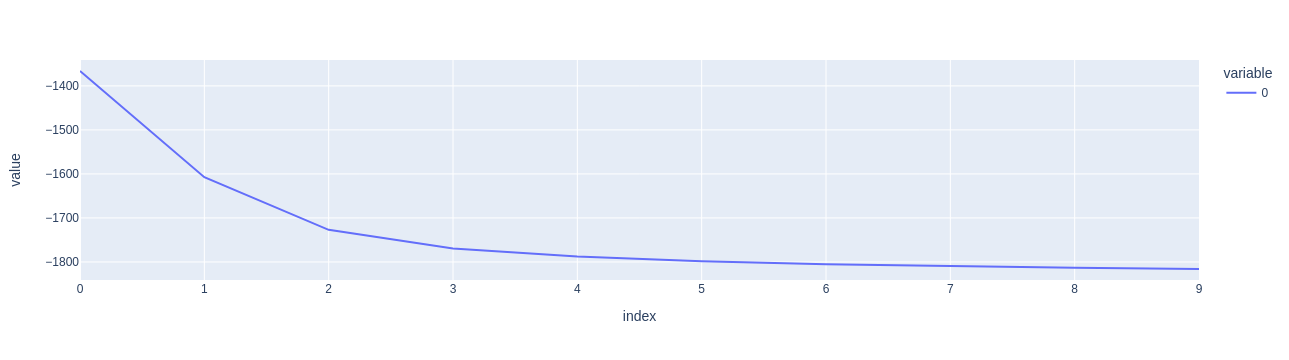

In [58]:
# The training loop of the VAE looks comparable to the training loop in Part 1,
# with the exception that we train in batches this time. 
# The number of Epochs can be set to a suitable value and will depend on the
# architecture. With the above architecture, a good fit can be reached after as little
# as ~20 Epochs. Beyond 100 Epochs, there is usually no meaningful improvement to the loss anymore.
# Due to the regularized nature of VAEs, they will not overfit for large numbers of Epochs.
EPOCHS = None

# We can use the boilerplate code defined in the beginning of the notebook to fetch
# the training and testing data.
train_loader, test_loader = None

# Again, it is good practice to clear the parameter store before training,
# to avoid interference with previous iterations.
pyro.clear_param_store()

# The training loop is analogous to Part 1. Feel free to print the training loss
# during the loop.
loss = []
for epoch in tqdm(range(EPOCHS), total=EPOCHS):
    epoch_loss = 0
    # Again, we can take a step in the parameterspace by calling the 'step'
    # method of the SVI. We do this for each batch.
    for batch, _ in train_loader:
        epoch_loss += svi.step(batch)
    
    # After we have trained on all batches for this epoch, 
    # we can normalize the epoch loss by the number of batches,
    # and append the epoch loss to the list of losses for later visualization.
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    loss.append(total_epoch_loss_train)
    if (epoch % 10) == 0:
        print(total_epoch_loss_train)

px.line(loss)

## 5. Generating Images with the Trained VAE

In this section, we will explore the capabilities of our trained Variational Autoencoder (VAE) by generating new images. By sampling from the learned latent space, we can generate novel data samples that capture the underlying patterns and variations present in the training dataset. We will examine the test loss, visualize the test images in a T-SNE projection of the latent space, and finally generate new images by sampling from the latent space distribution.

### 5.1 Test Loss

In this sub-section, we evaluate the performance of our trained VAE by calculating the test loss across all the testing samples. The test loss provides an indication of how well our VAE generalizes to unseen data. By comparing the test loss to the training loss, we can assess if the model exhibits overfitting or underfitting tendencies. A lower test loss suggests that the VAE has learned meaningful representations and can reconstruct the testing images effectively.

In [10]:
# As a quick sanity check, we can evaluate the losses on the testing data.
# If everything went well during training, we would expect a test loss of similar size
# as the training loss.

def evaluate(svi, test_loader):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # When calculating the loss on a test sample, make sure to call 
        # 'evaluate_loss' instead of 'step', to not take a step in the parameter space.
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

evaluate(svi=svi, test_loader=test_loader)

### 5.2 Test Images in T-SNE

In this sub-section, we visualize the test images in a T-SNE projection of the latent space. T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in a lower-dimensional space. By projecting the latent representations of the test images onto a 2D or 3D space, we can gain insights into the clustering and structure of the latent space. This visualization allows us to understand how well the VAE has captured the underlying data distribution and if similar images are grouped together.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 1.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.120756
[t-SNE] Computed conditional probabilities in 0.174s
[t-SNE] Iteration 50: error = 91.6081543, gradient norm = 0.0170774 (50 iterations in 1.453s)
[t-SNE] It

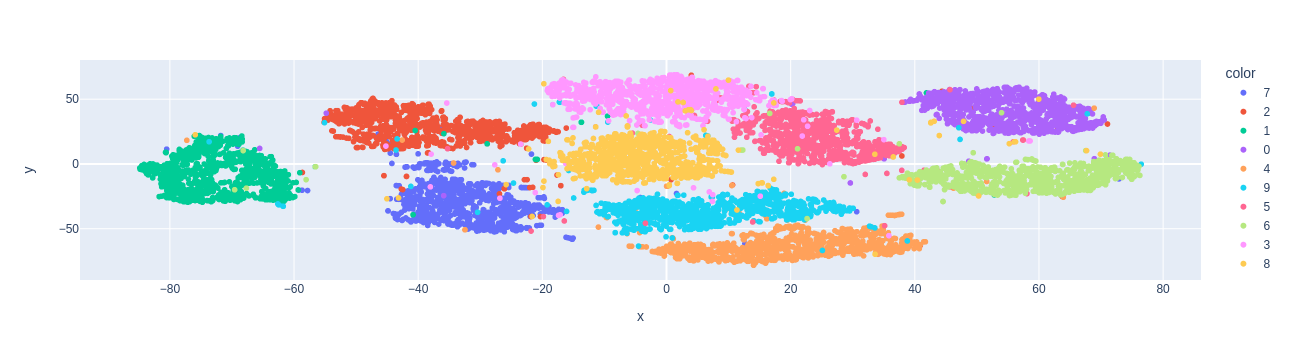

In [122]:
# To illustrate how the latent space will end up regularized and well ordered,
# we van visualize the test images in latent space.
# We would expect the same numbers to end up in the same cluster and expect
# clusters of similar numbers (such as 7 and 1) to end up relatively close to each other.
# The continuity of relative completeness is what enables Variational Autoencoders to
# generate new samples.

latent_images = [
    vae.encoder(img)[0].detach().cpu().numpy() for img, _ in test_loader
]
labels = [label.detach().cpu().numpy().astype(str) for _, label in test_loader]
labels = list(chain.from_iterable(labels))
latent_images = np.concatenate(latent_images, axis=0)


tsne = TSNE(n_components=2, n_jobs=-1, random_state=0, verbose=10)
latent_embedding = tsne.fit_transform(latent_images)
px.scatter(x=latent_embedding[:, 0], y=latent_embedding[:, 1], color=labels)

### 5.3 New Images

In this sub-section, we harness the power of the trained VAE to generate new images. By sampling from the learned latent space distribution, we can explore the generative capabilities of the model. We will randomly sample latent vectors from the prior distribution or systematically traverse the latent space to observe the variations in the generated images. This provides an exciting opportunity to create novel, never-before-seen images that resemble the patterns learned during training. We can adjust the latent variables to influence the generated images and explore the continuous variations in the generated samples.

By the end of this section, you will have a comprehensive understanding of the VAE's performance on the test dataset, visual insights into the latent space using T-SNE, and the ability to generate new images. Let's proceed and unlock the generative power of our trained VAE!

In [3]:
# Lastly, we can use our generative model to generate new images!
# If everything went well, we should find that a major share of
# generated images closely remsemble a real handwritten digit.
# However, the VAE we built in this workshop is only the first of a series
# of probabilistic generative models. Extensions, such as Conditinal VAEs further
# improve the quality and complexity of produced samples.

# To sampel from the latent space, we intialize a 1D torch tensor
# containing zeros. The length of the 0th axis inticates the number of samples
# we want to generate.
# We can pass these zeros through the model, which will provide us with samples
# from the latent space, with z_loc = 0 and z_scale = 1, as defined in the model method.
# We should make sure, that the generated sampels have the shape (N, 28, 28), where N is
# the number of images we sampled for.
zeros = None
sample_loc = None

# This is just a simple function to build a convenient generator to iterate on
def gen(imgs):
    for img in imgs:
        yield img

imgs = gen(imgs=sample_loc)

In [4]:
# You can use PIL's Image.fromarray functionality to display your individual images
# Note, that the pixel intensity is generated by our model as being between 0 and 1,
# but PIL expect it to be defined between 0 and 255.
Image.fromarray(None).resize((100, 100))

NameError: name 'Image' is not defined